In [21]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose
import numpy as np
import cv2

In [22]:
# Hyper-parameter
epochs = 10
batch_size = 256

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
transform = Compose([ToTensor(), Normalize(0, 1)])

In [25]:
train_data = FashionMNIST('data', train=True, transform=transform, download=True)
test_data = FashionMNIST('data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

In [26]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.conv_1 = nn.Conv2d(1, 6, (5, 5), padding=2)
        self.activation = nn.Sigmoid()
        self.pool = nn.AvgPool2d(2, 2)
        self.conv_2 = nn.Conv2d(6, 16, (5, 5))
        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        X = self.conv_1(X)
        X = self.activation(X)
        X = self.pool(X)
        X = self.conv_2(X)
        X = self.activation(X)
        X = self.pool(X)
        output = self.FC(X)
        return output

In [27]:
model = Module(); model.to(device)
optimizer = Adam(model.parameters(), 0.001)
loss = CrossEntropyLoss()
scheduler = StepLR(optimizer, 10, math.exp(-0.1))

In [28]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [29]:
history = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[]
}

In [36]:
for i in range(epochs):
    print('\033[33m' + f'Epoch {i + 1} Start' + '\33[0m')
    
    # Start Training
    train_acc = 0
    train_loss = 0
    
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        img, label = img.to(device), label.to(device)
        
        output = model(img)
        output_loss = loss(output, label)
        # Calculate
        train_acc += (output.argmax(dim=1) == label).sum().item()
        train_loss += output_loss.item()
        # BP
        output_loss.backward()
        optimizer.step()
    scheduler.step()
    train_acc = train_acc / len(train_data)
    train_loss /= len(train_loader)
    
    # Start Valuation
    test_acc = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img, label = img.to(device), label.to(device)
            
            output = model(img)
            output_loss = loss(output, label)
            # Calculate
            test_acc += (output.argmax(dim=1) == label).sum().item()
            test_loss += output_loss.item()
    test_acc = test_acc / len(test_data)
    test_loss /= len(test_loader)
    
    history['acc'].append(train_acc)
    history['loss'].append(train_loss)
    history['val_acc'].append(test_acc)
    history['val_loss'].append(test_loss)
    
    print(f'Train acc: {train_acc:.4f}, loss: {train_loss:.4f}')
    print(f'Test acc: {test_acc:.4f}, loss: {test_loss:.4f}')
    print('======================================')

Epoch 1 Start
Train acc: 0.8275, loss: 0.4670
Test acc: 0.8180, loss: 0.4858
Epoch 2 Start
Train acc: 0.8330, loss: 0.4538
Test acc: 0.8271, loss: 0.4697
Epoch 3 Start
Train acc: 0.8381, loss: 0.4415
Test acc: 0.8253, loss: 0.4637
Epoch 4 Start
Train acc: 0.8420, loss: 0.4303
Test acc: 0.8336, loss: 0.4478
Epoch 5 Start
Train acc: 0.8449, loss: 0.4226
Test acc: 0.8364, loss: 0.4417
Epoch 6 Start
Train acc: 0.8491, loss: 0.4112
Test acc: 0.8365, loss: 0.4365
Epoch 7 Start
Train acc: 0.8506, loss: 0.4055
Test acc: 0.8399, loss: 0.4259
Epoch 8 Start
Train acc: 0.8542, loss: 0.3994
Test acc: 0.8416, loss: 0.4263
Epoch 9 Start
Train acc: 0.8561, loss: 0.3897
Test acc: 0.8434, loss: 0.4151
Epoch 10 Start
Train acc: 0.8585, loss: 0.3845
Test acc: 0.8469, loss: 0.4085


In [37]:
def show(history:dict, name):
    plt.cla(); plt.clf()
    plt.plot(history[name], 'b', label='train')
    plt.plot(history['val_'+name], 'r', label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.title('Performance')
    plt.show()

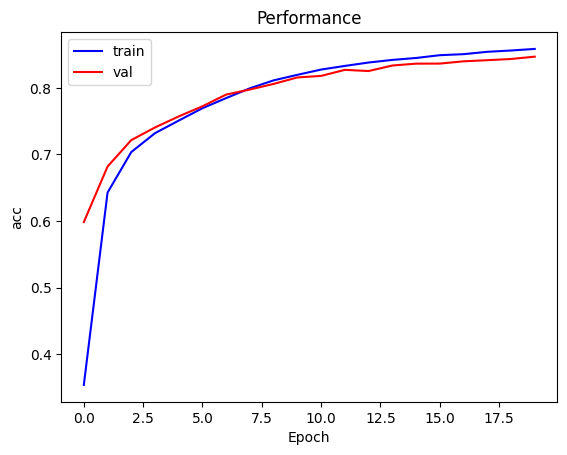

In [38]:
show(history, 'acc')

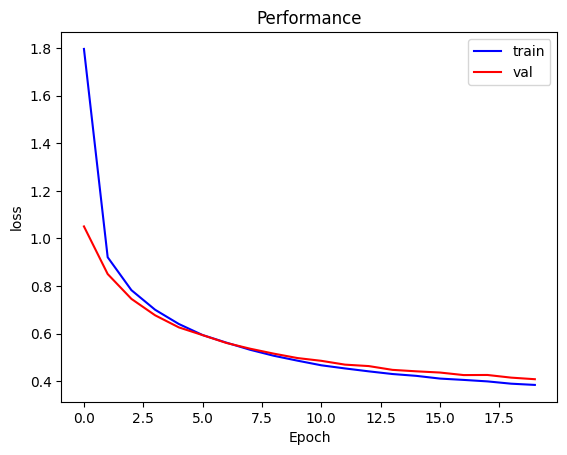

In [39]:
show(history, 'loss')

## Grad-CAM
 - [LINK](https://blog.csdn.net/qq_40243750/article/details/124322668)

In [40]:
def plot_cam(img, label, name):
    img = img.reshape(-1, *img.shape)
    
    grad_block = []	# for grad map
    feaure_block = []	# for feature map
    
    # 获取梯度的函数
    def backward_hook(module, grad_in, grad_out):
        grad_block.append(grad_out[0].detach())

    # 获取特征层的函数
    def forward_hook(module, input, output):
        feaure_block.append(output)
        
    def cam_show_img(img, feature_map, grads):
        cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
        grads = grads.reshape([grads.shape[0], -1])
        weights = np.mean(grads, axis=1)
        
        for i, w in enumerate(weights):
            cam += w * feature_map[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)
        cam = cam ** 0.5  # 增強對比
        cam = cv2.resize(cam, (28, 28))
        
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET).astype(np.float32) / 255.0
        
        img = img.numpy()
        cv2.imwrite(f"org_{name}_{label}.jpg", img * 255)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        if img.shape[-1] != 3:
            img = np.repeat(img, 3, axis=-1)
        
        cam_img = 0.5 * heatmap + 0.5 * img
        cam_img = np.uint8(cam_img * 255)
        
        cam_img = cv2.resize(cam_img, (200, 200))
        cv2.imwrite(f"cam_{name}_{label}.jpg", cam_img)
        
    target_layer = dict(model.named_modules())['conv_2']
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    model.eval()
    # forward 
    # 在前向推理时，会生成特征图和预测值
    output = model(img)
    max_idx = np.argmax(output.cpu().data.numpy())
    print("predict:{}".format(max_idx))
    if max_idx != label: return
    
    # backward
    model.zero_grad()
    # 取最大类别的值作为loss，这样计算的结果是模型对该类最感兴趣的cam图
    class_loss = output[0, label]	
    class_loss.backward()	# 
    
    # grads
    grads_val = grad_block[0].cpu().data.numpy().squeeze()
    fmap = feaure_block[0].cpu().data.numpy().squeeze()
    # 我的模型中
    # grads_cal.shape=[1280,2,2]
    # fmap.shape=[1280,2,2]

    # save cam
    cam_show_img(img.reshape(28, 28, 1), fmap, grads_val)

In [41]:
for i in range(100):
    img, label = test_data[i]
    plot_cam(img, label, train_data.classes[label])

predict:9
predict:2
predict:1
predict:1
predict:6
predict:1
predict:4
predict:6
predict:5
predict:7
predict:4
predict:5
predict:5
predict:3
predict:4
predict:1
predict:2
predict:2
predict:8
predict:0
predict:2
predict:7
predict:7
predict:5
predict:1
predict:2
predict:6
predict:0
predict:9
predict:6
predict:8
predict:8
predict:3
predict:3
predict:8
predict:0
predict:7
predict:5
predict:7
predict:9
predict:0
predict:1
predict:0
predict:9
predict:6
predict:7
predict:2
predict:1
predict:2
predict:6
predict:2
predict:2
predict:5
predict:8
predict:2
predict:2
predict:8
predict:4
predict:8
predict:0
predict:7
predict:7
predict:8
predict:5
predict:1
predict:1
predict:6
predict:4
predict:7
predict:8
predict:7
predict:0
predict:2
predict:6
predict:4
predict:3
predict:1
predict:2
predict:8
predict:4
predict:1
predict:8
predict:5
predict:9
predict:5
predict:0
predict:3
predict:2
predict:0
predict:2
predict:5
predict:3
predict:6
predict:7
predict:1
predict:8
predict:0
predict:1
predict:4
predict:2
